# Intent Analysis on chat bot data

Chat bots are increasingly used to automate online customer queries and negate the need for call center staff.

Here we will train a Long Short Term Memory (LSTM) network to suggest the intent of a customer based on the text of the input query.

[LSTM](https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470) networks are great for text classification problems because they have memory (e.g. would be able to identify the word "not" before "good" as a negative sentiment). This sequential context is something that humans take for granted but that is very difficult for computers to grasp.


In [1]:
#import dependencies
import pandas as pd
import keras
import numpy as np
import utils
import os
import matplotlib.pylab as plt
from sklearn.metrics.pairwise import cosine_similarity

# Load train and test sample

We will load separately the train and test data. The Xtrain and ytrain respectively will contain a list of the query (one list element per sample) and the outcome label (16 possibilities).

In [2]:
#intent analysis atis dataset 
dftrain = pd.read_csv('./data/datasets_117486_281522_atis.train.csv')
Xtrain, ytrain = list(dftrain.values[:,1]), list(dftrain.values[:,-1])

dftest = pd.read_csv('./data/datasets_117486_281522_atis.test.csv')
Xtest, ytest = list(dftest.values[:,1]), list(dftest.values[:,-1])

# One-hot encode labels

We will be predicting the probability that an input beloings to each class. For each label, we therefore need a vector of 1s and 0s where 1 appears next to the correct label, and all incorrect labels are zero.

In [3]:
#one hot encode labnels
ytrain = pd.get_dummies(ytrain)
labels = list(ytrain.columns)
nlabels = len(labels)
ytrain = np.array(ytrain)
ytest = pd.get_dummies(ytest)
ytest = np.array(ytest)

# Tokenization

We now map each word to an integer identifier. The list sample is then converted into a vector of integers corresponding to each word. For shorter inputs, we padd the start with zeros so that each sample has the same input vector length. 

Since there are so many words collectively in the full dataset, we keep only the 50 most common in each sample to avoid overfitting our classifier.

In [4]:
#convert all abstracts to sequences of integers key stored in idx_word
tokenizer = keras.preprocessing.text.Tokenizer(num_words=50,
                                               filters="?!':;,.#$&()*+-<=>@[\\]^_`{|}~\t\n",
                                               lower=True, split=' ')
tokenizer.fit_on_texts(Xtrain)
#assign an integer ID to each word
Xtrain_sequence = tokenizer.texts_to_sequences(Xtrain)
#padd the sequences of short sentences with 0s so everything is the same length
Xtrain_sequence = keras.preprocessing.sequence.pad_sequences(Xtrain_sequence,
                                                             padding='post')

#record the word to ID map and count the number of words in our vocabulary (+ 1 as we have the 0 padding as a word)
idx_word = tokenizer.index_word
num_words = len(idx_word) + 1

# Word Embeddings

We need a mathematical way to represent 'words' in vector form such that words with similar meaning have vectors that point in similar directions. i.e. "plant" and "flower" would have similar pointing vectors in this abstract "Embedding Vector Space", but that vectors for words like "Hot" and "Cold" would point in opposite directions. Training these word embeddings is a herculean task even with monstrous amounts of computing power (not at all suitable for a Macbook). Fortunately, we can load a pre-trained word embedding dictionary like GloVe. GloVe is an unsupervised learning algorithm for representing words as vectors. In this representation, the cosine angle between two word vectors provides an effective method for measuring the linguistic or semantic similarity of the corresponding words as required. GloVe includes several pre-trained word embedding vocabularies. This work uses the 100d vector version with a vocabulary size of 400,000. 

In [5]:
# if word embeddings are not already present, download them here
word_embeddings_link = 'http://nlp.stanford.edu/data/glove.6B.zip'
word_embeddings_unzipped_file = 'glove.6B.zip'
word_embeddings_file = 'glove.6B.100d.txt'
word_embeddings_path = './data_nontracked'#../disaster_nlp/data/non_tracked/glove.6B.100d.txt'
if os.path.isdir(word_embeddings_path) is False:
    os.system('mkdir '+word_embeddings_path)
if os.path.isfile(word_embeddings_path+'/'+word_embeddings_file) is False:
    os.system('wget '+word_embeddings_link+' -P '+word_embeddings_path)
    os.system('unzip '+word_embeddings_path+'/'+word_embeddings_unzipped_file+' -d '+word_embeddings_path)

In [6]:
#load in word embeddings
embeddings_dict = utils.load_embeddings(word_embeddings_path+'/'+word_embeddings_file)
embeddings_words = list(embeddings_dict.keys())
wordvec_dim = embeddings_dict[embeddings_words[0]].shape[0]
embedding_matrix = np.zeros((num_words,wordvec_dim))
for i, word in idx_word.items():
    # Look up the word embedding
    vector = embeddings_dict.get(word, None)
    # Record in matrix
    if vector is not None:
        embedding_matrix[i, :] = vector

# Fit the model

We now build the LSTM model. Many neural nets share similar features. If we want to assign the probability to each class of a given input, the output will always be a Dense layer with softmax activation function equal to the number of labels. If we want a positive / negative decision, the output will be a single neuron with a sigmoid loss. The differences with LSTMs are the input 'Embedding' layer, where we specify our newly loaded word embeddings, and the number of input training samples and size of our vocabulary.

In [7]:
#Initialise the usual sequential network
model_lstm = keras.Sequential()

#initialise Ebedding layer
# input_length is the number of words ids per sample e.g 28
# NOT the sample size of the training data
# you do not need to supply that info
model_lstm.add(keras.layers.Embedding(input_dim=num_words,
                                      input_length=Xtrain_sequence.shape[1],
                                      output_dim=wordvec_dim,
                                      weights=[embedding_matrix],
                                      trainable=False,
                                      mask_zero=True))

#words which are not in the pretrained embeddings (with value 0) are ignored
model_lstm.add(keras.layers.Masking(mask_value = 0.0))

# Recurrent layer
model_lstm.add(keras.layers.LSTM(64, activation='relu'))

# Dropout for regularisation and avoid overfit
model_lstm.add(keras.layers.Dropout(0.5))

# Output layer
model_lstm.add(keras.layers.Dense(nlabels,activation = 'softmax' ))

# Compile the model
model_lstm.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summarise the model
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 28, 100)           86500     
_________________________________________________________________
masking (Masking)            (None, 28, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 17)                1105      
Total params: 129,845
Trainable params: 43,345
Non-trainable params: 86,500
_________________________________________________________________


# Fit the model to the training data

In [8]:
model_lstm.fit(Xtrain_sequence, ytrain,epochs=5)

Epoch 1/5
134/134 [==============================] - 2s 17ms/step - loss: 1.2309 - accuracy: 0.7204
Epoch 2/5
134/134 [==============================] - 2s 17ms/step - loss: 0.8556 - accuracy: 0.7845
Epoch 3/5
134/134 [==============================] - 2s 17ms/step - loss: 0.7009 - accuracy: 0.8280
Epoch 4/5
134/134 [==============================] - 2s 17ms/step - loss: 0.6208 - accuracy: 0.8444
Epoch 5/5
134/134 [==============================] - 2s 17ms/step - loss: 0.5765 - accuracy: 0.8484


# Transform the test data using the tokenizer and evaluate the model performance

In [9]:
#Transform the test data
Xtest_sequence = tokenizer.texts_to_sequences(Xtest)
Xtest_sequence = keras.preprocessing.sequence.pad_sequences(Xtest_sequence,
                                                            maxlen = Xtrain_sequence.shape[1],
                                                            padding='post')

In [10]:
#evaluate model performance
eval_lstm = model_lstm.evaluate(Xtest_sequence, ytest)
ypred = model_lstm.predict(Xtest_sequence)

19/19 [==============================] - 0s 5ms/step - loss: 0.5254 - accuracy: 0.8549


# Convert Class probabilities into predictions

For simplicity we simply take the class with the largest probability to be the prediction

In [11]:
#multiclass problem, pick highest probability as the choice
ypred_choices = ypred*0
cnt = 0
for yp in ypred:
    idx = np.argmax(yp)
    ypred_choices[cnt,idx] = 1
    cnt += 1

# Confusion Matrix Performance Analysis

Here we see where the classifier performs well and where any mis-classifications are most common. Given we have an class abundance bias, the normalised confusion matrix is plotted below.

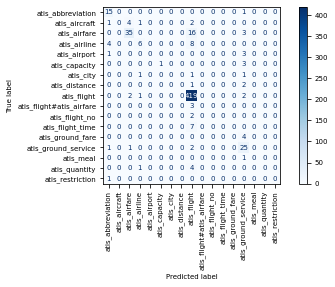

In [12]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
cm = metrics.confusion_matrix(ytest.argmax(axis=1), ypred_choices.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
plt.rcParams.update({'font.size': 7})
# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(xticks_rotation=90,cmap='Blues')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

The confusion matrics shows where the model has a tendancy to correctly predict a target label, and where it falls down. There are two types of misclassification errors possible with a binary label problem. Type 1 (or False Positive) errors occur where the model incorrectly assigns a sample as belonging to the positive class. Type 2 (False Negative) errors indicate where a positive classification is missed. The difference with a multiclass problem such as this is that any misclassification error will be both Type 1 and Type 2, since a false positive with respect to one label will simultaneously be a false negative with respect to another.  

We can condense the confusion matrix into a single metric to score the models ability to classify each label. We consider the models false positive and negative performance with respect to each label and calculate a quantity, F1, that is the harmonic mean of precision and recall. 

$F_1 = \frac{TP}{TP + 0.5 \left( FP + FN \right)}$.

For a label with all items correctly classified, $F_1=1$. The quantity then declines as misclassifications increase.

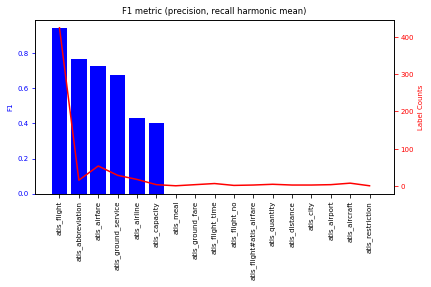

In [13]:
#Now make a plot showing the F1 score (harmonic mean precision recall)
true_pos = np.diag(cm)
false_pos = np.sum(cm, axis = 0) - true_pos
false_neg = np.sum(cm, axis = 1) - true_pos
f1 = true_pos / (true_pos + 0.5*(false_pos + false_neg))

fig = plt.figure()
ax1 = fig.add_subplot(111)
idxsort = np.argsort(f1)[-1::-1]
x = np.arange(len(labels))
y = f1[idxsort]
ax1.bar(x,y,color='b')
ax1.set_xticks(x)
ax1.set_xticklabels(np.array(labels)[idxsort])
ax1.set_ylabel('F1',color='b')
ax1.spines['left'].set_color = 'blue'
ax1.set_title('F1 metric (precision, recall harmonic mean)')
ax1.tick_params(axis='x',rotation=90)
ax1.tick_params(axis='y',colors='blue')
#overplot the label counts on a second axis
ax2 = ax1.twinx()
counts = np.sum(cm,axis=1)
ax2.plot(x, counts[idxsort],color='r',label='label counts')
ax2.spines['right'].set_color = 'red'
ax2.set_ylabel('Label Counts',color='r')
ax2.tick_params(axis='y',colors='red')
plt.tight_layout()
plt.savefig('F1_score.png')

# Summary

We see that the LSTM model generally performs well for the 'flight', 'abbreviation', 'airfare' and 'ground service' querries with and $F_1$ score above 0.6. The performance then decays rapidly toward zero for the remaining classes. This is likely due to a combination of the following.

### Class Imballance
We see from the label counts that the VAST majority of samples in our dataset belong to the 'flight' class. During training this skews the model to accurately predicting this single class. Indeed we see a general correlation between $F_1$ score and label abundance. One potential wayt to overcome this problem is to re-phrase the question out model asks. We can turn this multi-class problem into a binary class problem that predicts 'Flight query or NOT Flight query'. This is a common approach to overcoming class imballance in commercial classification problems.


### Training Time
In this problem we train the LSTM for only 5 epochs. This is somewhat low for most LSTM problems of this complexity and traditionaly we would expect to train the model for longer. One typically guards against overfit in instances with large numbers of training epochs by isolating a separate 'validation' sample. After each epoch of training we compare the training loss with the loss of the model-predicted validation sample. The training loss will continue to decrease with additional epochs of training but the validation loss will at some point stop falling and begin to rise. The epoch in which the validation loss is minimised typicall indicates when to stop training but this is likely to be significantly more than the 5 epochs shown here. 